<a href="https://www.kaggle.com/code/giuliobenedetti/learning-about-ad?scriptVersionId=154754389" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

df_cross = pd.read_csv("/kaggle/input/mri-and-alzheimers/oasis_cross-sectional.csv")
df_long = pd.read_csv("/kaggle/input/mri-and-alzheimers/oasis_longitudinal.csv")

# Preliminary Exploration

## Data Cleaning

In [2]:
# Rename cols to match names in df_cross
df_long = df_long.rename(columns={"MRI ID": "ID", "EDUC": "Educ", "MR Delay": "Delay"})

# Create columns for easy distinction between the cohorts
df_cross["Cohort"] = "OASIS1"
df_long["Cohort"] = "OASIS2"

# Concatenate df_cross with df_long
df = pd.concat([df_cross, df_long])

# Drop rows with missing target variable
df.dropna(subset=["CDR"], inplace=True)

# Remove cols with only one distinct value
df.drop(["Hand"], axis=1, inplace=True)

# Use ID as row index
df.index = df.pop("ID")

In [3]:
from sklearn import preprocessing

# Create LabelEncoder
le = preprocessing.LabelEncoder()
# Encode original CDR from (0, 0.5, 1, 1.5, 2) to (0, 1, 2, 3)
df["CDR"] = le.fit_transform(df["CDR"])

# Split preprocessed datasets
df_cross = df.loc[df["Cohort"] == "OASIS1", ]
df_long = df.loc[df["Cohort"] == "OASIS2", ]

## Visualisation

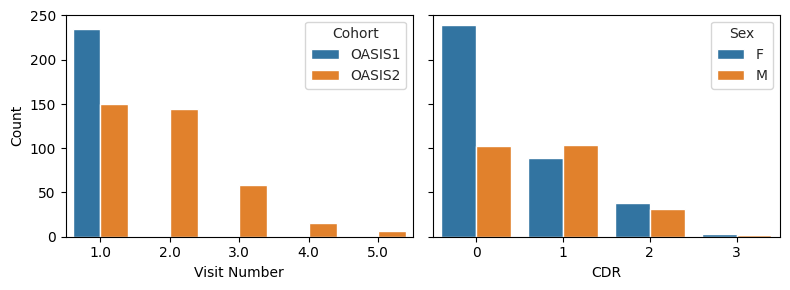

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns

df["Visit"] = df["Visit"].fillna(value=1)

ncol = 2
fig, axes = plt.subplots(1, ncol, sharey=True)

fig.set_figheight(3)
fig.set_figwidth(8)
sns.set_style("ticks")

sns.countplot(df, x="Visit", hue="Cohort", ax=axes[0])
axes[0].set_xlabel("Visit Number")
axes[0].set_ylabel("Count")

sns.countplot(df, x="CDR", hue="M/F", ax=axes[1])
axes[1].set_ylabel("")
axes[1].legend(title="Sex")

plt.tight_layout()

In [5]:
grouped_df = df.groupby(["Visit", "CDR"]).size()
size_arr = df.groupby("Visit").size().values

count_df = pd.DataFrame({
    "Visit": [i[0] for i in grouped_df.index],
    "CDR": [i[1] for i in grouped_df.index],
    "Count": grouped_df.values
})

count_df["Percentage"] = count_df["Count"] / count_df["Visit"].map(lambda x: size_arr[round(x) - 1]) * 100

Text(0, 0.5, 'Relative Percentage (%)')

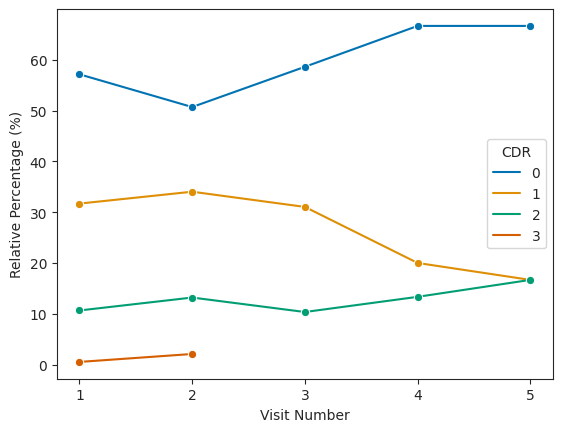

In [6]:
sns.lineplot(
    count_df, x="Visit", y="Percentage",
    hue="CDR", palette="colorblind",
    marker="o"
)

plt.xlabel("Visit Number")
plt.xticks(range(1, 6))

plt.ylabel("Relative Percentage (%)")

In [7]:
from sklearn import decomposition
from scipy import stats

# Drop target, categorical variables and metadata
X = df.drop(["CDR", "Delay", "Subject ID", "Group", "Visit", "M/F", "Cohort"], axis=1)

# Impute SES on the fly
X["SES"] = X["SES"].map(lambda x: stats.mode(X["SES"])[0] if np.isnan(x) else x)
# Impute MMSE on the fly
X["MMSE"] = X["MMSE"].map(lambda x: np.nanmedian(X["MMSE"]) if np.isnan(x) else x)

# Create PCA
pca = decomposition.PCA(n_components=2)
# Perform PCA
red_dims = pca.fit_transform(X)

In [8]:
def plot_pca(red_dims, hue, ax, palette="colorblind", s=15):
    
    sns.scatterplot(
    x=red_dims[:, 0], y=red_dims[:, 1],
    hue=hue, palette=palette,
    s=s, ax=ax
    )

ncol, nrow = 3, 2
my_palette = sns.color_palette("viridis", as_cmap=True)

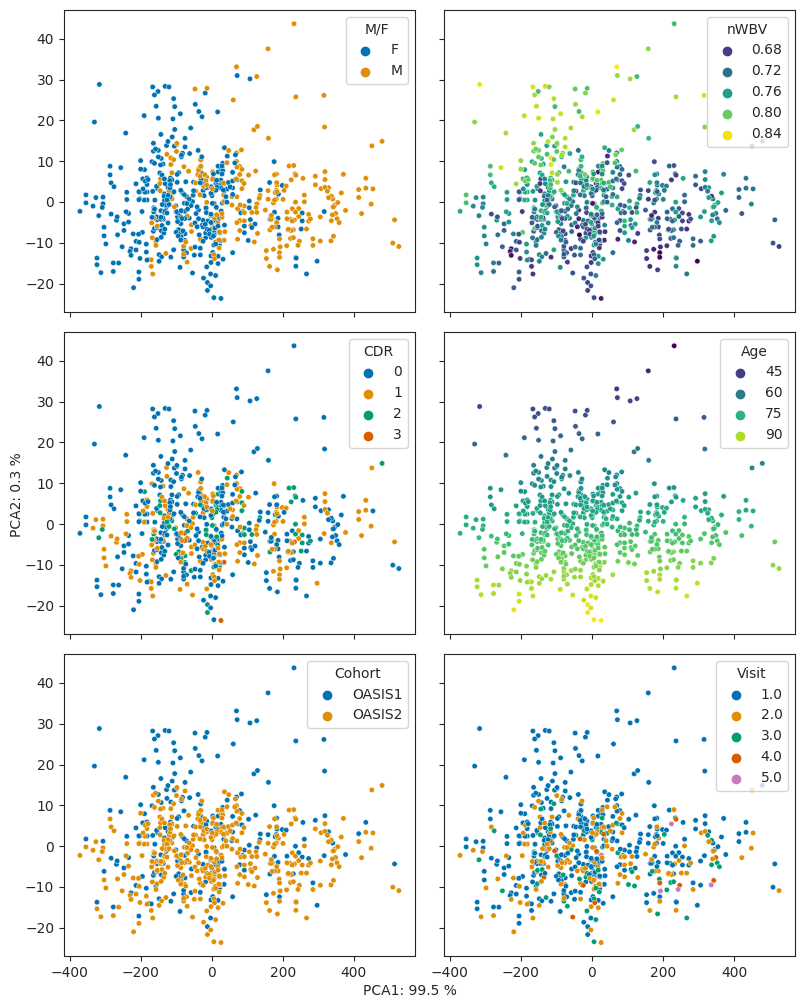

In [9]:
fig, axes = plt.subplots(ncol, nrow, sharex=True, sharey=True)

fig.set_figheight(5 * nrow)
fig.set_figwidth(8)
sns.set_style("ticks")

plot_pca(red_dims, df["M/F"], axes[0, 0])
plot_pca(red_dims, df["nWBV"], axes[0, 1], palette=my_palette)
plot_pca(red_dims, df["CDR"], axes[1, 0])
plot_pca(red_dims, df["Age"], axes[1, 1], palette=my_palette)
plot_pca(red_dims, df["Cohort"], axes[2, 0])
plot_pca(red_dims, df["Visit"], axes[2, 1])

fig.text(0.5, 0, f"PCA1: {pca.explained_variance_ratio_[0] * 100:.1f} %", ha="center")
fig.text(0, 0.5, f"PCA2: {pca.explained_variance_ratio_[1] * 100:.1f} %", va="center", rotation="vertical")

plt.tight_layout()

<Axes: >

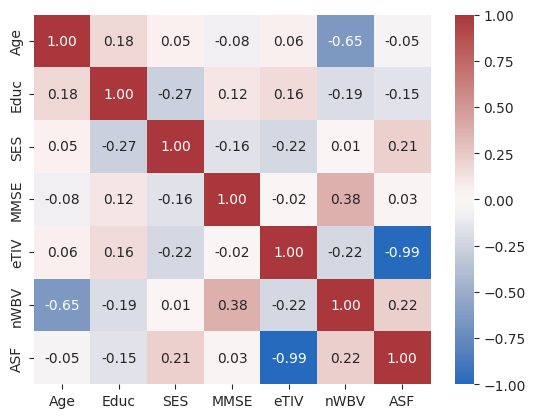

In [10]:
corr = X.corr()
sns.heatmap(
    corr, cmap="vlag", annot=True,
    fmt=".2f", annot_kws={'size': 10},
    vmin=-1, vmax=1
)

# Cross-Sectional Analysis

(expand).

## Preprocessing

train/test split (expand).

In [11]:
from sklearn import model_selection as ms

# Split dataframe into features (X) and target (y)
def X_y_split(df, target="CDR", drop_cols=["Delay", "Subject ID", "Group", "Visit", "Cohort"]):
    
    X = df.drop(drop_cols, axis=1)
    y = X.pop(target)
    
    return X, y

# Split X and y for cross-sectional dataset
X_cross, y_cross = X_y_split(df_cross)

# Set fraction of data allocated to the test set 
test_fraction = 0.1

# Split train/devel set from test set
X_train, X_test, y_train, y_test = ms.train_test_split(
    X_cross, y_cross,
    test_size=test_fraction,
    stratify=y_cross,
    random_state=123,
)

Feature Imputation (expand).

In [12]:
from sklearn.impute import SimpleImputer

# Given a uniform distribution, impute SES with mode
ses_imputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
# Given a skewed distribution, impute MMSE with median
mmse_imputer = SimpleImputer(missing_values=np.nan, strategy="median")

# Apply SES imputer to data
X_train["SES"] = ses_imputer.fit_transform(X_train[["SES"]])
X_test["SES"] = ses_imputer.transform(X_test[["SES"]])

# Apply MMSE imputer to data
X_train["MMSE"] = mmse_imputer.fit(X_train[["MMSE"]])
X_test["MMSE"] = mmse_imputer.transform(X_test[["MMSE"]])

**Data normalisation** helps standardise features and speed up learning. Thus, data is normalised by scaling numerical variables and one-hot encoding categorical ones. Ordinal variables may also need normalisation, but options for this type have not been found yet.

In [13]:
from sklearn.compose import make_column_transformer

# Categorise variables by type
categorical_vars = ["M/F"]
numerical_vars = ["Age", "Educ", "eTIV", "nWBV", "ASF"]
ordinal_vars = ["Educ", "SES", "MMSE"]

# Build preprocessor
preprocessor = make_column_transformer(
    (preprocessing.StandardScaler(), numerical_vars),
    (preprocessing.OneHotEncoder(), categorical_vars)
)

# Apply preprocessor to data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

## Validation Performance

Currently, the criterion to select the most performant model is based on two validation metrics: accuracy and confusion matrix. The former gives a general measure of the classification power, whereas the latter provides a more detailed insight into the bias of the model. It may be useful to validate the models with other metrics which put more weight on the rare classes, that is, the demented subjects.

In [14]:
# Set k equal to the number of occurrences of least populated class
#k_folds = y_train.value_counts().min()
k_folds=10

# Create stratified K-fold validator
skf = ms.StratifiedKFold(
    n_splits=k_folds,
    shuffle=True,
    random_state=123
)

In [15]:
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix

# Perform model validation based on k-fold cross-validation
def validate_model(model, X, y, metric=accuracy_score, **kwargs):
    
    scorer = make_scorer(metric)
    score = ms.cross_val_score(
        model,
        X, y,
        scoring=scorer,
        **kwargs
    )
    
    return score

# Generate confusion matrix based on k-fold cross validation
def make_confusion_matrix(model, X, y, **kwargs):
    
    y_pred = ms.cross_val_predict(
        model,
        X, y,
        **kwargs
    )
    
    conf_mat = confusion_matrix(y, y_pred)
    
    return conf_mat

_What is the minimal performance that we should expect from a model?_ This question can be answered by setting a **baseline performance**. This usually corresponds to the accuracy obtained with a very simple model, such as a classifier that predicts everything to be the most frequent class. The latter approach is applied here to estimate a baseline performance for the cross-sectional and longitudinal datasets as well as the combined dataset.

In [16]:
from sklearn.dummy import DummyClassifier

# Compute baseline performance based on given strategy
def baseline_performance(X, y, strategy="most_frequent"):
    
    dummy_clf = DummyClassifier(strategy=strategy)
    dummy_clf.fit(X, y)
    dummy_clf.predict(X)
    
    return dummy_clf.score(X, y)

print(f"Baseline performance for cross-sectional data: {baseline_performance(X_cross, y_cross) * 100:.2f}%")

Baseline performance for cross-sectional data: 57.45%


The baseline performance remains similar among the three datasets with an average of around 56%. This is the minimum accuracy that we want to achieve with a more suitable model.

# Model Selection

The candidate models include:
- cost-sensitive SVM
- Decision tree
- Random forest
- K neighbours

To add a new model, you can simply import it from a package, create it and store it in the dictionary of classifiers under a name of your choice.

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Prepare empty dictionary to store models
models = {}

# Create SVM classifier and add to dictionary
models["SVM"] = SVC(random_state=123)
# Create decision tree classifier and add to dictionary
models["Tree"] = DecisionTreeClassifier(random_state=123)
# Create random forest classifier
models["Random Forest"] = RandomForestClassifier(random_state=123)
# Create k-neighbours classifier
models["K-Neighbours"] = KNeighborsClassifier()

### Add new models here ###
# models["name"] = model()

In [18]:
# Validate models with accuracy
scores = list(map(lambda model: validate_model(model, X_train, y_train, cv=skf).mean(), models.values()))
scores = dict(zip(models.keys(), scores))

# Validate models with a confusion matrix
confusion_matrices = list(map(lambda model: make_confusion_matrix(model, X_train, y_train, cv=skf), models.values()))
confusion_matrices = dict(zip(models.keys(), confusion_matrices))

Accuracy of SVM: 0.639
Accuracy of Tree: 0.492
Accuracy of Random Forest: 0.569
Accuracy of K-Neighbours: 0.559


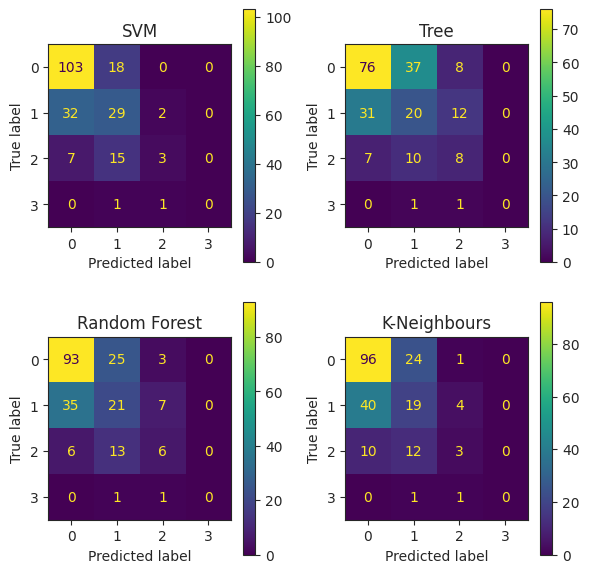

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

ncol = 2
model_num = len(models)
nrow = round(np.ceil(model_num / ncol))

fig, axes = plt.subplots(nrow, ncol)

fig.set_figheight(3 * nrow)
fig.set_figwidth(3 * ncol)

# Print validation profile for each model
for idx, (name, model) in enumerate(models.items()):

    print(f"Accuracy of {name}: {scores[name].mean():.3f}")
    
    if idx == 0:
        row_idx = 0
    elif idx % ncol == 0:
        row_idx += 1
    
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrices[name])
    disp.plot(ax=axes[row_idx, idx % ncol])
    disp.ax_.set_title(name)

plt.tight_layout()

# Hyperparameter Tuning

_How can we optimise the selected model to improve performance?_ The answer to this question lies in **hyperparameter tuning**. Here, the goal consists in finding the combination of values for the model hyperparameters in order to achieve the best possible performance. This is usually done with a grid search, which can be either full or randomised. The former searches over the full grid for the actual best combination, whereas the latter only searches over a random subset of the grid. Randomised grid search reduces the computational demand while still providing a nearly optimal combination of values, for which reason it is applied below.

In [20]:
# Select the best classifier algorithm
selected_model = models[max(scores, key=scores.get)]

# View the best classifier algorithm
selected_model

SVC(random_state=123)

In [21]:
from functools import reduce

# Provide parameters to optimise and grid values
param_grid = {"C": [1, 10, 100, 1000],
              "kernel": ["linear", "poly", "rbf", "sigmoid"],
              "degree": [2, 3, 4, 5],
              "gamma": ["auto", "scale"]}

# Convert parameter grid to list
grid_values = list(param_grid.values())
# Compute number of possible combinations (full grid)
full_search_iter = reduce(lambda x, y: x * len(y), grid_values[1:], len(grid_values[0]))

# Perform randomised search for best combination of parameters
tuned_models = ms.RandomizedSearchCV(
    estimator=selected_model,
    param_distributions=param_grid,
    n_iter=min(full_search_iter, 60), 
    scoring=make_scorer(accuracy_score),
    cv=skf,
    random_state=123
)

In [22]:
# Train tuned models
tuned_models.fit(X_train, y_train)

# Select the best model in terms of accuracy
tuned_model = tuned_models.best_estimator_

# View the best model
tuned_model

SVC(C=1000, degree=5, kernel='linear', random_state=123)

# Model Assessment

After selecting and tuning the best model, it is finally time to test its performance on the test set. Getting nervous, how well will it do?

In [23]:
# Predict CDR of test set with best tuned model
tuned_model.fit(X_train, y_train)
y_pred = tuned_model.predict(X_test)

print(f"Accuracy of best tuned model: {accuracy_score(y_test, y_pred):.3f}")

Accuracy of best tuned model: 0.458
